# SIMWE, Part 2

Part 1 must be run before using this notebook; we use outputs created in Part 1 during this tutorial.

In Part 1, we created a hypothetical rainstorm event, accounted for vegetation interception and immediate infiltration of the water into the soil. In this notebook, we will use [r.sim.water](https://grass.osgeo.org/grass82/manuals/r.sim.water.html) to surface water flow during the storm then look at the hydrographs at the outflow of the stream to see how our swales impacted the total flow.

## Part 2.1 Start GRASS GIS

In [1]:
import subprocess
import sys
import matplotlib.pyplot as plt
import numpy as np

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True, shell=False).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("./data/simwe/");

## Part 2.2 Preparing to Model Overland Flow with Preferential Flow along the Stream Channel
We're going to  use [r.sim.water](https://grass.osgeo.org/grass82/manuals/r.sim.water.html) to simulate our flood event. The r.sim.water module is a GRASS implementation of SIMWE (SImulated Water Erosion) ; it uses a Monte Carlo path sampling method to solve the St. Venant surface water flow differential equations (these are also called momentum conservation equations):

$$i_e=\frac{dh}{dt}+\frac{dhv_x}{dt}+\frac{dhv_y}{dt}$$

where:

$i_e$ is rainfall excess (runoff), rainfall minus infiltration and vegetation intercept [m/s] 

$v$ is flow velocity, given by Manning’s equation shown below [m/s] 

$t$ is time [s] 

And velocity is given by Manning’s equation:

$$v = \frac{k}{n}h^{\frac{2}{3}}s^{\frac{1}{2}}s_0$$

where:

$n$ is dimensionless Manning's roughness coefficient (property of land cover)

$k$ is corresponding dimension constant, value 1 [$m^{\frac{1}{3}}$/s]

$s$ is slope steepness [m/m]

$s_0$ is the unit vector in the flow direction

This Monte Carlo process uses “walkers” or particles that simulate the path and speed of a drop of water over the surface. The speed and path of the particles are determined by the surface roughness (via Manning’s equation) and the gradient of the slope. At each time step some portion of the particles can also infiltrate into the soil and are removed from the simulation. The resulting density of the particles at each timestep determines the water depth and discharge. 

#### Create Manning's Coefficient Raster

Before we can run r.sim.water, we need to create some of the inputs to the equation shown above. We have our rainfall excess created in Part 1 but we still need a raster of our Manning's constant (surface roughness coefficent), infiltration of overland flow rate, and the gradient of the surface. Manning's coefficient is a function of land cover so we can use a similar approach to the vegetation interception and immediate infiltration where we reclassify the landcover raster to surface roughness values. These pairs are found in [land_to_mannings.txt](./land_to_mannings.txt).

In [2]:
gs.run_command("r.recode", input="landcover_filled", output="mannings", rules="land_to_mannings.txt")
gs.run_command("r.recode", input="lc_buff15", output="mannings15", rules="land_to_mannings.txt")
gs.run_command("r.recode", input="lc_buff30", output="mannings30", rules="land_to_mannings.txt")

#### Create Infiltration Rate Raster for Overland Flow

If our imaginary raindrop infiltrated the soil when it first fell, then we can assume the soil is now somewhat saturated. As the storm progresses, the infiltration rate will also decrease as the soil approaches saturation. To account for this, we'll make a new infiltration raster, "infiltration_overland_flow" that has an infiltration rate 10x smaller than the initial infiltration rate.

In [3]:
gs.mapcalc("infiltration_overland_flow = if(infiltration==0, 0, infiltration/10)") # use an if statement to avoid division by 0
gs.mapcalc("infiltration_overland_flow15 = if(infiltration15==0, 0, infiltration15/10)")
gs.mapcalc("infiltration_overland_flow30 = if(infiltration30==0, 0, infiltration30/10)")

#### Institute a Culvert with Preferential Stream Flow

Finally, there's also a culvert in our study area where runoff runs under the road. Before we can compute the partial derivatives of the slope (gradient), we need to give the stream preferential flow direction under the road. First, we convert the stream vector to a raster so we can compute the stream's gradient. Using `v.to.rast`'s `use=dir ` method, we assign each cell value to the stream's direction (i.e. the direction the stream is flowing in).  

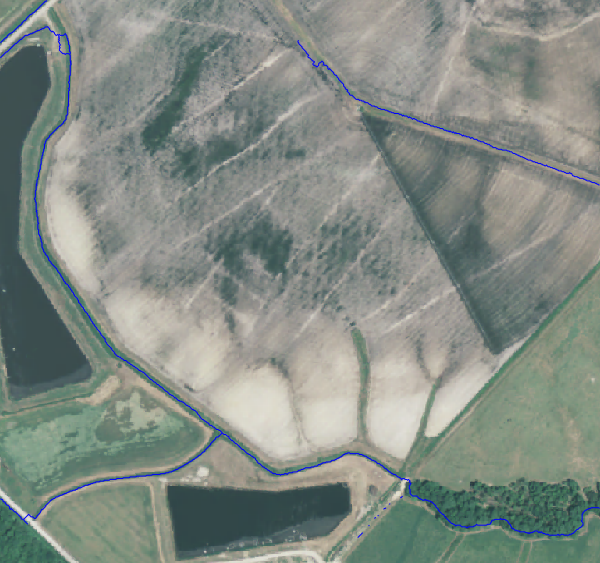

In [5]:
img = gj.Map(use_region=True)
img.d_rgb(red="naip_20140523.1", green="naip_20140523.2", blue="naip_20140523.3")
img.d_vect(map="all_streams", color="blue")
img.show()

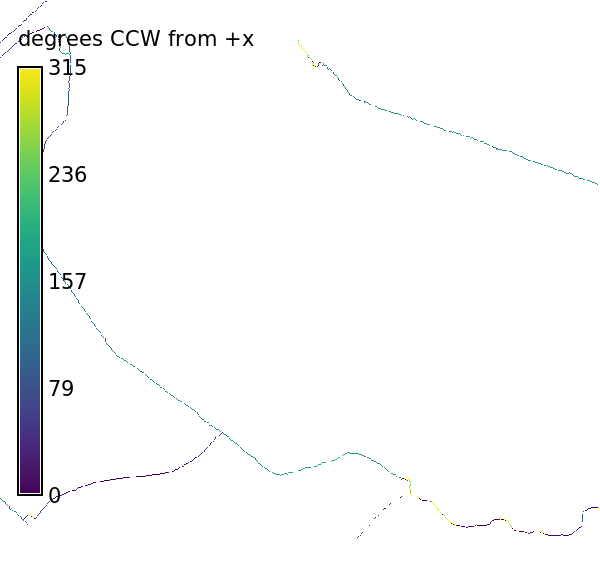

In [6]:
gs.run_command("v.to.rast", input="all_streams", output="streams_dir", use="dir")

img = gj.Map(use_region=True)
img.d_rast(map="streams_dir")
img.d_legend(raster="streams_dir")
# Display map
img.show()

Then, we convert the downstream direction to gradient by including a slope angle of 2 degrees. We use the formula:

$$ \frac{\delta z}{\delta x} = \tan(\beta)*\cos(\alpha) $$

$$ \frac{\delta z}{\delta y} = \tan(\beta)*\sin(\alpha) $$

Where $\beta$ is the slope and $\alpha$ is the stream direction.

In [7]:
gs.mapcalc("dx_stream = tan(2.)*cos(streams_dir)")
gs.mapcalc("dy_stream = tan(2.)*sin(streams_dir)")

Compute partial derivatives with _[r.slope.aspect](https://grass.osgeo.org/grass80/manuals/r.slope.aspect.html)_.

In [8]:
gs.run_command("r.slope.aspect",
               elevation="be_dem", 
               dx="dx_no_culvert",
               dy="dy_no_culvert")

Now, we can combine our preferential flow direction with the gradient rasters computed from the DEM to make a new gradients that will allow water to flow over the road where the stream is.

In [9]:
#Compute flow gradient vector by combining dx and dy derived from the DEM and stream:
gs.mapcalc("dx = if(isnull(dx_stream), dx_no_culvert, dx_stream)")
gs.mapcalc("dy = if(isnull(dy_stream), dy_no_culvert, dy_stream)")

Let's take a quick peak at our partial derivatives.

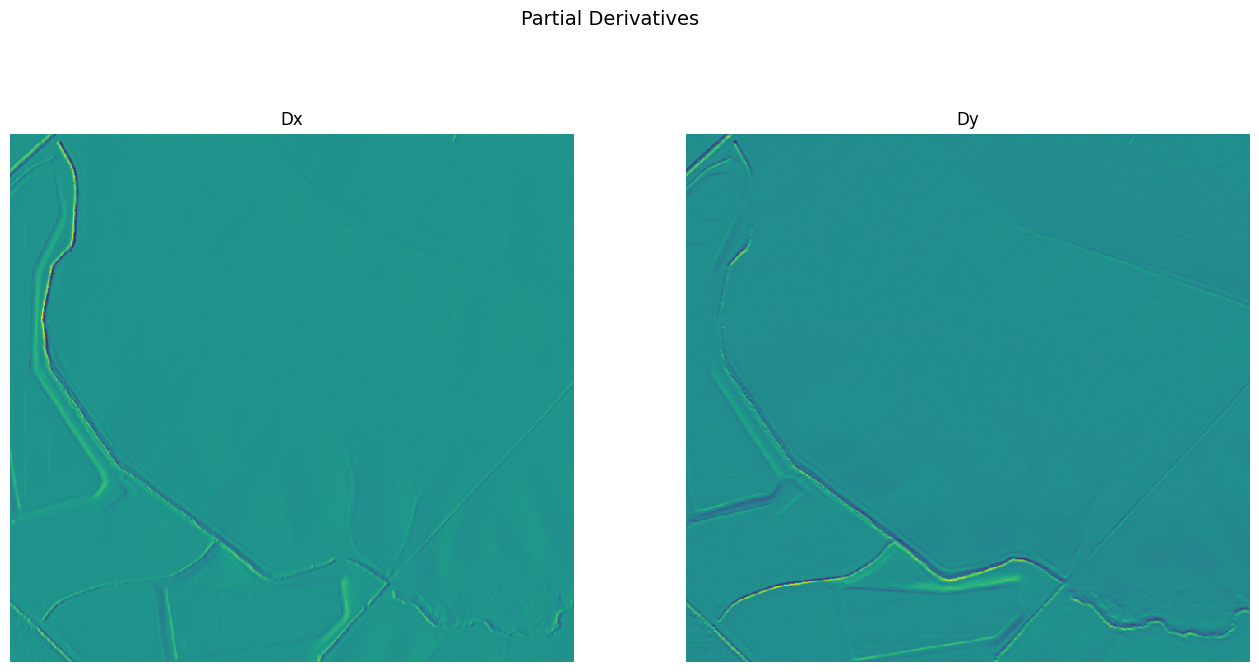

In [11]:
dx=gj.Map()
dx.d_rast(map="dx")

dy=gj.Map()
dy.d_rast(map="dy")

plt.rcParams['figure.figsize'] = [16, 8]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Partial Derivatives', fontsize=14)
ax1.imshow(plt.imread(dx.filename))
ax1.axis('off')
ax1.set_title("Dx")
ax2.imshow(plt.imread(dy.filename))
ax2.axis('off')
ax2.set_title("Dy");

## Part 2.3 Modeling Surface Water Flow during a Storm

Now, we compute spatial pattern of overland flow depth and discharge by running the SIMWE model implemented in the _[r.sim.water](https://grass.osgeo.org/grass80/manuals/r.sim.water.html)_ module. We set ninterations to 30 and increment to 2 so our output will be 30 minutes of rainfall with depth and discharge rasters saved every 2 minutes. This may take a minute to run.

First, we'll simulate the storm without any swales. Increase the increment to decrease the runtime (less data writing).

In [12]:
# Output time step increment
increment = 1

gs.run_command("r.sim.water",
               elevation="be_dem",
               dx="dx",
               dy="dy", 
               rain="rainfall_excess",
               infil="infiltration_overland_flow",
               man="mannings",
               depth="depth",
               discharge="disch",
               nwalkers=100000,
               niterations=30,
               output_step=increment,
               flags="t");

Then, with 15 meter swales

In [13]:
gs.run_command("r.sim.water",
               elevation="be_dem",
               dx="dx",
               dy="dy", 
               rain="rainfall_excess15",
               infil="infiltration_overland_flow15",
               man="mannings15",
               depth="depth15",
               discharge="disch15",
               nwalkers=100000,
               niterations=30,
               output_step=increment,
               flags="t");

And finally with 30 meter swales

In [14]:
gs.run_command("r.sim.water",
               elevation="be_dem",
               dx="dx",
               dy="dy", 
               rain="rainfall_excess30",
               infil="infiltration_overland_flow30",
               man="mannings30",
               depth="depth30",
               discharge="disch30",
               nwalkers=100000,
               niterations=30,
               output_step=increment,
               flags="t");

Let's checkout the final discharge map after 30 minutes of heavy rain.

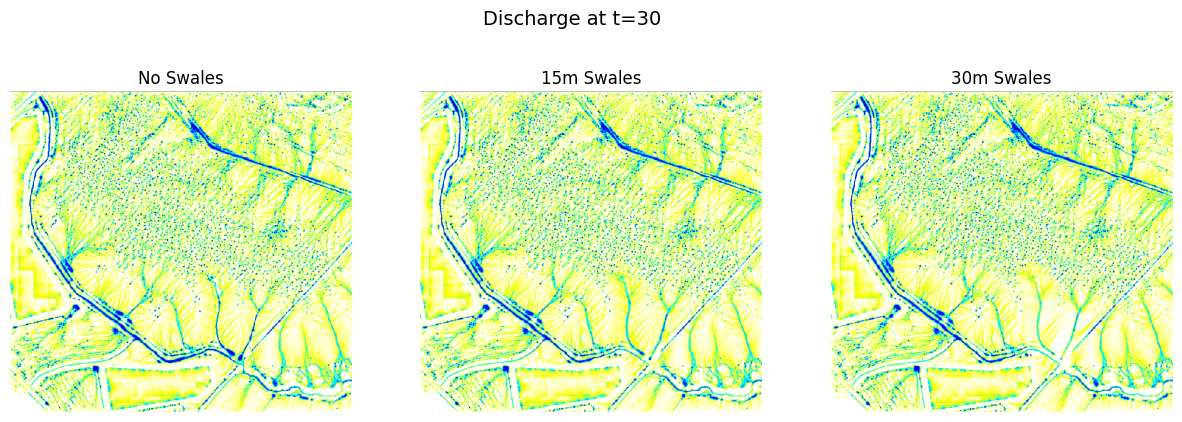

In [15]:
# Make sure all the color ramps are the same
gs.run_command("r.colors", map="disch15.30", raster="disch.30") 
gs.run_command("r.colors", map="disch30.30", raster="disch.30") 

out=gj.Map()
out.d_rast(map="disch.30")

out15=gj.Map()
out15.d_rast(map="disch15.30")
out30=gj.Map()
out30.d_rast(map="disch30.30")

plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Discharge at t=30', fontsize=14)
ax1.imshow(plt.imread(out.filename))
ax1.axis('off')
ax1.set_title("No Swales")
ax2.imshow(plt.imread(out15.filename))
ax2.axis('off')
ax2.set_title("15m Swales");
ax3.imshow(plt.imread(out30.filename))
ax3.axis('off')
ax3.set_title("30m Swales");

And also the final water depth map

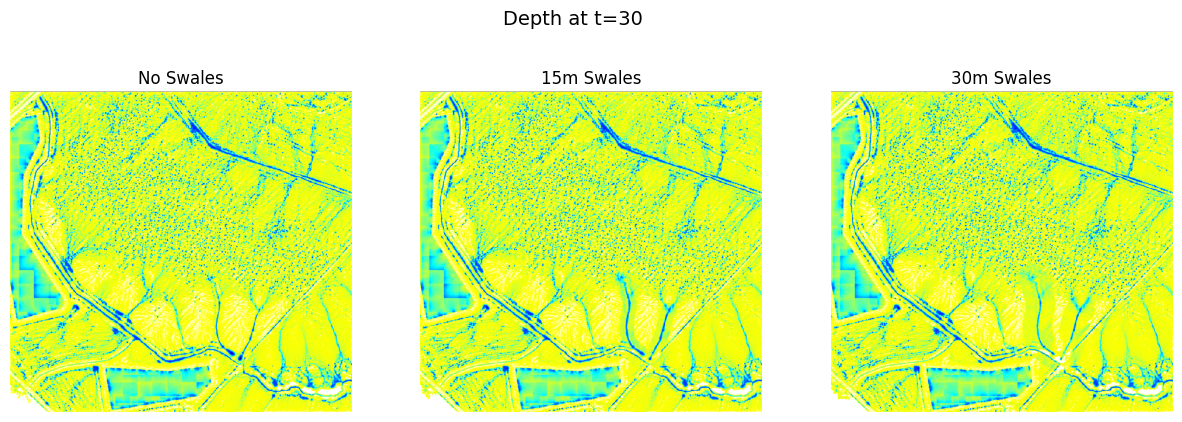

In [16]:
out=gj.Map()
out.d_rast(map="depth.30")

out15=gj.Map()
out15.d_rast(map="depth15.30")

out30=gj.Map()
out30.d_rast(map="depth30.30")

plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Depth at t=30', fontsize=14)
ax1.imshow(plt.imread(out.filename))
ax1.axis('off')
ax1.set_title("No Swales")
ax2.imshow(plt.imread(out15.filename))
ax2.axis('off')
ax2.set_title("15m Swales");
ax3.imshow(plt.imread(out30.filename))
ax3.axis('off')
ax3.set_title("30m Swales");

In [18]:
!r.relief input=be_dem output=be_dem_shaded_relief

   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Shaded relief raster map <be_dem_shaded_relief> complete


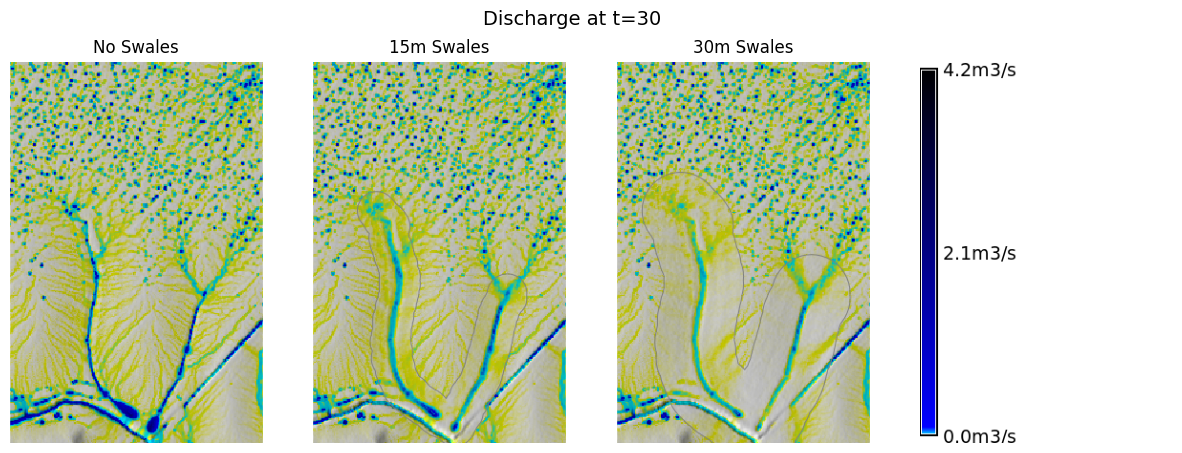

In [19]:
out=gj.Map(saved_region="buffer_area")
out.d_shade(shade="be_dem_shaded_relief", color="disch.30", brighten=20)

out15=gj.Map(saved_region="buffer_area")
out15.d_shade(shade="be_dem_shaded_relief", color="disch15.30", brighten=20)
out15.d_vect(map="buffer15", fill_color="none", color="gray")

out30=gj.Map(saved_region="buffer_area")
out30.d_shade(shade="be_dem_shaded_relief", color="disch30.30", brighten=20)
out30.d_vect(map="buffer30", fill_color="none", color="gray")

outleg=gj.Map(saved_region="buffer_area")
outleg.d_legend(raster="disch.30", at=(2,98,0,7), units="m3/s", labelnum=3, border_color="none")

plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.suptitle('Discharge at t=30', fontsize=14)
ax1.imshow(plt.imread(out.filename))
ax1.axis('off')
ax1.set_title("No Swales")
ax2.imshow(plt.imread(out15.filename))
ax2.axis('off')
ax2.set_title("15m Swales");
ax3.imshow(plt.imread(out30.filename))
ax3.axis('off')
ax3.set_title("30m Swales")
ax4.imshow(plt.imread(outleg.filename))
ax4.axis('off');

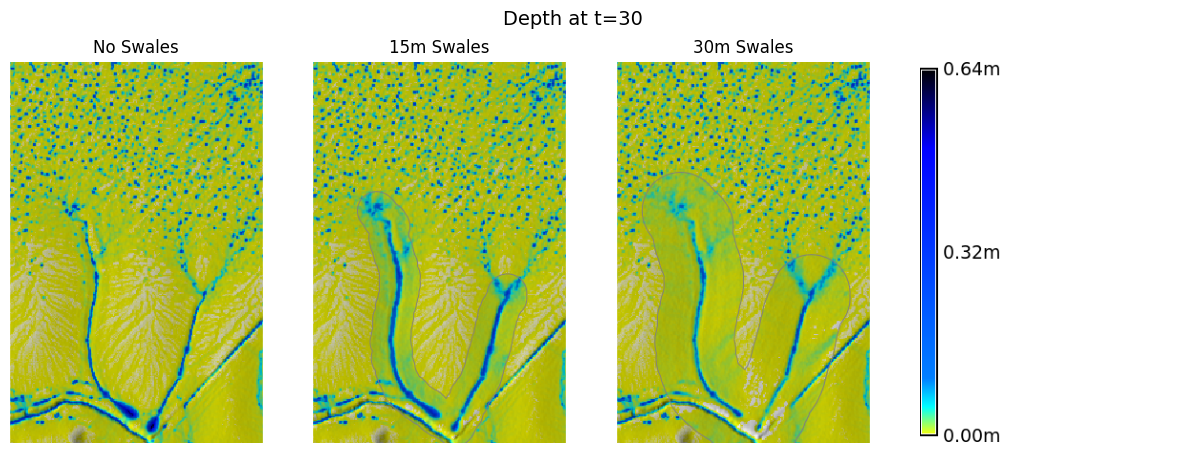

In [21]:
out=gj.Map(saved_region="buffer_area")
out.d_shade(shade="be_dem_shaded_relief", color="depth.30", brighten=20)

out15=gj.Map(saved_region="buffer_area")
out15.d_shade(shade="be_dem_shaded_relief", color="depth15.30", brighten=20)
out15.d_vect(map="buffer15", fill_color="none", color="gray")

out30=gj.Map(saved_region="buffer_area")
out30.d_shade(shade="be_dem_shaded_relief", color="depth30.30", brighten=20)
out30.d_vect(map="buffer30", fill_color="none", color="gray")

outleg=gj.Map(saved_region="buffer_area")
outleg.d_legend(raster="depth.30", at=(2,98,0,7), units="m", labelnum=3, border_color="none")

plt.rcParams['figure.figsize'] = [15, 5]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.suptitle('Depth at t=30', fontsize=14)
ax1.imshow(plt.imread(out.filename))
ax1.axis('off')
ax1.set_title("No Swales")
ax2.imshow(plt.imread(out15.filename))
ax2.axis('off')
ax2.set_title("15m Swales");
ax3.imshow(plt.imread(out30.filename))
ax3.axis('off')
ax3.set_title("30m Swales")
ax4.imshow(plt.imread(outleg.filename))
ax4.axis('off');

## Hydrographs

Hydrographs are a popular method for tracking discharge and studying floods. In this section, we install a hypothetical water level gauge at the outflow of our study area. Then, we'll sample the discharge rasters at that location for each timestep in our simulation. Then we can plot the flood and compare the impact of our swales on discharge.

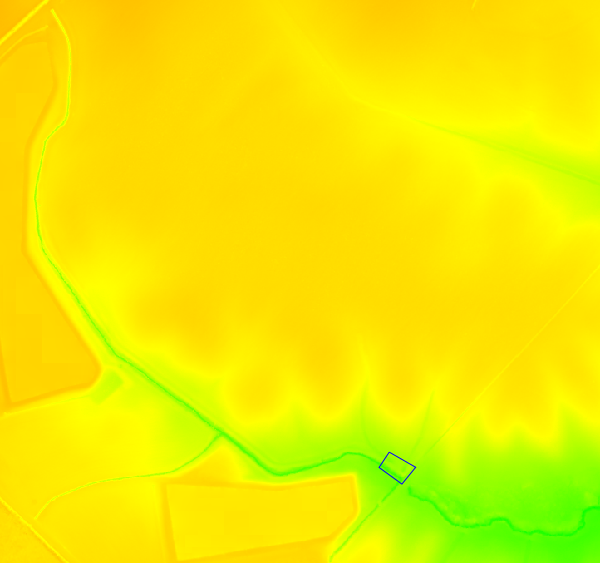

In [22]:
img=gj.Map(saved_region="TL1")
img.d_rast(map="be_dem")
img.d_vect(map="stream_gauge", fill_color="none", color="blue")
img.show()

In [23]:
!v.to.rast input=stream_gauge output=stream_gauge use=cat

Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
v.to.rast complete.


In [24]:
# list of no veg discharge rasters
disch_nobuff = gs.read_command("g.list", type="raster", pattern="disch.*", separator="comma").strip().split(",")

hydrograph_nobuff = []
for raster in disch_nobuff:
    stats = gs.read_command("r.univar", flags="g", map=raster, zones="stream_gauge").strip().split("\n")
    hydrograph_nobuff.append(float(stats[7][5:]))

In [25]:
# list of 15 meter swales discharge rasters
disch_buff15 = gs.read_command("g.list", type="raster", pattern="disch15.*", separator="comma").strip().split(",")

hydrograph_buff15 = []
for raster in disch_buff15:
    stats = gs.read_command("r.univar", flags="g", map=raster, zones="stream_gauge").strip().split("\n")
    hydrograph_buff15.append(float(stats[7][5:]))

In [26]:
# list of 30 meter swales discharge rasters
disch_buff30 = gs.read_command("g.list", type="raster", pattern="disch30.*", separator="comma").strip().split(",")

hydrograph_buff30 = []
for raster in disch_buff30:
    stats = gs.read_command("r.univar", flags="g", map=raster, zones="stream_gauge").strip().split("\n")
    hydrograph_buff30.append(float(stats[7][5:]))

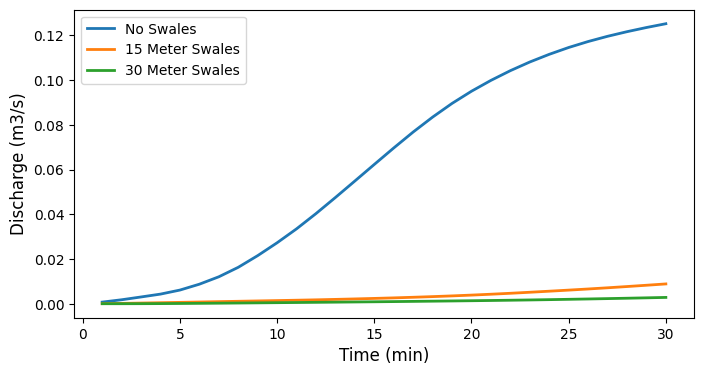

In [30]:
time = np.arange(1,31,1)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot each data series with custom line styles and colors
ax.plot(time, hydrograph_nobuff, label="No Swales", linewidth=2)
ax.plot(time, hydrograph_buff15, label="15 Meter Swales", linewidth=2)
ax.plot(time, hydrograph_buff30, label="30 Meter Swales", linewidth=2)

# Add labels and title with custom font properties
ax.set_xlabel('Time (min)', fontsize=12)
ax.set_ylabel('Discharge (m3/s)', fontsize=12)

# Add a legend
ax.legend(fontsize=10, loc='upper left')

# Show the plot
plt.show()

#### _Conclusion: Swales decrease flood flashiness by absorbing water and reducing runoff velocity!_